In [1]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

longLats = pickle.load(open('./longLat.pkl', 'rb'))
len(longLats)

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
df = df[(df.town=="SENGKANG") & (df.date > date_max-12)]

from pathlib import Path
file = Path('./data/Sengkang_June22_May23.csv')
df.to_csv(file,index=False)
df


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129122,SENGKANG,2 ROOM,467B,FERNVALE LINK,47.0,Model A,2016,93 years 04 months,300000.0,5.0,65.0
129123,SENGKANG,2 ROOM,418A,FERNVALE LINK,38.0,Model A,2018,95 years 02 months,300000.0,20.0,65.0
129124,SENGKANG,2 ROOM,445A,FERNVALE RD,47.0,Model A,2012,89 years 06 months,320000.0,20.0,65.0
129125,SENGKANG,2 ROOM,180B,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,315000.0,8.0,65.0
129126,SENGKANG,2 ROOM,180A,RIVERVALE CRES,47.0,Model A,2015,91 years 10 months,305000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153582,SENGKANG,EXECUTIVE,119C,RIVERVALE DR,142.0,Premium Apartment,2001,76 years 11 months,850000.0,14.0,76.0
153583,SENGKANG,EXECUTIVE,189B,RIVERVALE DR,131.0,Apartment,2000,76 years 03 months,660000.0,8.0,76.0
153584,SENGKANG,EXECUTIVE,189A,RIVERVALE DR,131.0,Apartment,2000,76 years 04 months,710000.0,17.0,76.0
153585,SENGKANG,EXECUTIVE,324C,SENGKANG EAST WAY,127.0,Apartment,2002,78 years 02 months,750000.0,5.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

responses = []
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    if (i%10==0):
      print(f"{first_response['label']}, confidence {first_response['confidence']}, {i} of {len(blk_street.unique())}")
  else:
    print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


In [6]:
errors = [
  "501A YISHUN ST 51",
  "501B YISHUN ST 51",
  "502A YISHUN ST 51",
  "502B YISHUN ST 51",
  "502C YISHUN ST 51",
  "506A YISHUN AVE 4",
  "506B YISHUN AVE 4",
  "506C YISHUN AVE 4",
  "507A YISHUN AVE 4",
  "508A YISHUN AVE 4",
  "508B YISHUN AVE 4",
  "509A YISHUN AVE 4",
  "509B YISHUN AVE 4",
  "509C YISHUN AVE 4",
  "502D YISHUN ST 51",
  "513A YISHUN ST 51",
  "513B YISHUN ST 51",
  "513C YISHUN ST 51",
  "513D YISHUN ST 51",
  "676A YISHUN RING RD",
  "676B YISHUN RING RD",
  "676C YISHUN RING RD",
  "677A YISHUN RING RD",
  "677B YISHUN RING RD",
  "677C YISHUN RING RD",
]
len(errors)

25

In [7]:
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129678,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 03 months,280000.0,11.0,65.0
129679,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 02 months,280000.0,11.0,65.0
129680,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 02 months,281000.0,8.0,65.0
129681,YISHUN,2 ROOM,671B,YISHUN AVE 4,47.0,Model A,2018,94 years 08 months,315000.0,5.0,65.0
129682,YISHUN,3 ROOM,431C,YISHUN AVE 1,67.0,Model A,2015,92 years 04 months,402000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
154058,YISHUN,5 ROOM,502B,YISHUN ST 51,112.0,Improved,2018,93 years 08 months,710000.0,8.0,76.0
154059,YISHUN,5 ROOM,504D,YISHUN ST 51,113.0,Improved,2016,91 years 10 months,658888.0,5.0,76.0
154060,YISHUN,EXECUTIVE,661,YISHUN AVE 4,164.0,Apartment,1992,68 years 02 months,1050000.0,8.0,76.0
154061,YISHUN,EXECUTIVE,359,YISHUN RING RD,146.0,Maisonette,1988,64 years 03 months,810000.0,5.0,76.0


In [9]:
dfL = df[(~df.block.str.startswith('501'))&(~df.block.str.startswith('502'))&(~df.block.str.startswith('506'))&(~df.block.str.startswith('507'))&(~df.block.str.startswith('508'))
        &(~df.block.str.startswith('509'))&(~df.block.str.startswith('513'))&(~df.block.str.startswith('676'))&(~df.block.str.startswith('677'))]
file = Path('./data/Yishun_June22_May23_without_newest.csv')
dfL.to_csv(file,index=False)
dfL

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129678,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 03 months,280000.0,11.0,65.0
129679,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 02 months,280000.0,11.0,65.0
129680,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 02 months,281000.0,8.0,65.0
129681,YISHUN,2 ROOM,671B,YISHUN AVE 4,47.0,Model A,2018,94 years 08 months,315000.0,5.0,65.0
129682,YISHUN,3 ROOM,431C,YISHUN AVE 1,67.0,Model A,2015,92 years 04 months,402000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
154057,YISHUN,5 ROOM,511A,YISHUN ST 51,113.0,Improved,2017,93 years 03 months,605000.0,5.0,76.0
154059,YISHUN,5 ROOM,504D,YISHUN ST 51,113.0,Improved,2016,91 years 10 months,658888.0,5.0,76.0
154060,YISHUN,EXECUTIVE,661,YISHUN AVE 4,164.0,Apartment,1992,68 years 02 months,1050000.0,8.0,76.0
154061,YISHUN,EXECUTIVE,359,YISHUN RING RD,146.0,Maisonette,1988,64 years 03 months,810000.0,5.0,76.0


In [13]:
df[(df.block.str.startswith('501'))|(df.block.str.startswith('502'))|(df.block.str.startswith('506'))|(df.block.str.startswith('507'))|(df.block.str.startswith('508'))
        |(df.block.str.startswith('509'))|(df.block.str.startswith('513'))|(df.block.str.startswith('676'))|(df.block.str.startswith('677'))].describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date
count,187.000000,187.0,187.000000,187.000000,187.000000
mean,94.438503,2018.0,567107.101604,7.294118,70.272727
std,19.099913,0.0,110343.100408,3.419444,3.414935
min,38.000000,2018.0,315000.000000,2.000000,65.000000
25%,92.500000,2018.0,517500.000000,5.000000,67.000000
50%,93.000000,2018.0,560000.000000,8.000000,70.000000
75%,113.000000,2018.0,667500.000000,11.000000,73.000000
max,120.000000,2018.0,780000.000000,14.000000,76.000000


In [10]:
df = pd.read_csv('./data/Yishun_June22_May23_without_newest.csv')
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
0,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 03 months,280000.0,11.0,65.0
1,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 02 months,280000.0,11.0,65.0
2,YISHUN,2 ROOM,459,YISHUN AVE 11,48.0,Model A,2013,90 years 02 months,281000.0,8.0,65.0
3,YISHUN,2 ROOM,671B,YISHUN AVE 4,47.0,Model A,2018,94 years 08 months,315000.0,5.0,65.0
4,YISHUN,3 ROOM,431C,YISHUN AVE 1,67.0,Model A,2015,92 years 04 months,402000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
1834,YISHUN,5 ROOM,511A,YISHUN ST 51,113.0,Improved,2017,93 years 03 months,605000.0,5.0,76.0
1835,YISHUN,5 ROOM,504D,YISHUN ST 51,113.0,Improved,2016,91 years 10 months,658888.0,5.0,76.0
1836,YISHUN,EXECUTIVE,661,YISHUN AVE 4,164.0,Apartment,1992,68 years 02 months,1050000.0,8.0,76.0
1837,YISHUN,EXECUTIVE,359,YISHUN RING RD,146.0,Maisonette,1988,64 years 03 months,810000.0,5.0,76.0


In [11]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,1839.00000,1839.000000,1.839000e+03,1839.000000,1839.000000,1839.000000,1839.000000
mean,91.62099,1995.777597,4.787154e+05,6.882545,70.366504,103.838961,1.426118
std,22.88566,13.579453,1.217548e+05,3.539043,3.394050,0.005983,0.006773
min,38.00000,1978.000000,2.800000e+05,2.000000,65.000000,103.826943,1.412122
25%,73.00000,1986.000000,3.880000e+05,5.000000,67.000000,103.833787,1.420101
50%,92.00000,1988.000000,4.550000e+05,8.000000,70.000000,103.839664,1.426432
75%,104.00000,2015.000000,5.380000e+05,11.000000,73.000000,103.843548,1.432047
max,181.00000,2018.000000,1.080000e+06,14.000000,76.000000,103.849550,1.440387


In [12]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()

,floor,floor_area_sqm,lease_commence_date,date,lat,long,resale_price
0,8.0,83.000000,1987.0,71.0,1.422242,103.839348,420000.0
1,2.0,122.000000,1986.0,67.0,1.434859,103.829346,520000.0
2,11.0,84.000000,1988.0,71.0,1.422022,103.846436,390000.0
3,8.0,122.000000,1987.0,67.0,1.425978,103.832611,608000.0
4,5.0,66.999999,2018.0,72.0,1.417458,103.832428,475000.0
5,14.0,96.000000,2016.0,71.0,1.430229,103.844788,560000.0
6,8.0,104.000001,1988.0,72.0,1.414033,103.837753,482000.0
7,14.0,92.000000,2015.0,75.0,1.433771,103.842964,570000.0
8,5.0,120.999999,1985.0,71.0,1.432785,103.839401,550000.0
9,5.0,120.999999,1985.0,75.0,1.431553,103.832787,600000.0


In [13]:
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
#learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
#learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [19]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 30138.92578125.


(#2) [914265408.0,30138.92578125]

In [29]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 30576.142578125.


(#2) [979451840.0,30576.142578125]

In [20]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*15
n2 = 8*15
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  print(f"{i} of {n1}")
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    _, yPred, _ = learn.predict(row)
    prices[i][j] = yPred.item()

In [34]:
import http.client, urllib.parse
import json

mrts = ["Khatib MRT", "Yishun MRT"]

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    first_response = json.loads(data.decode('utf-8'))['data'][0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


Napier MRT Station, Singapore, confidence 1
Napier MRT Station, Singapore, confidence 1


1574

In [35]:
longLats["Yishun MRT"] = (103.83502,1.42934)
longLats["Khatib MRT"] = (103.83302,1.41735)

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)

1574

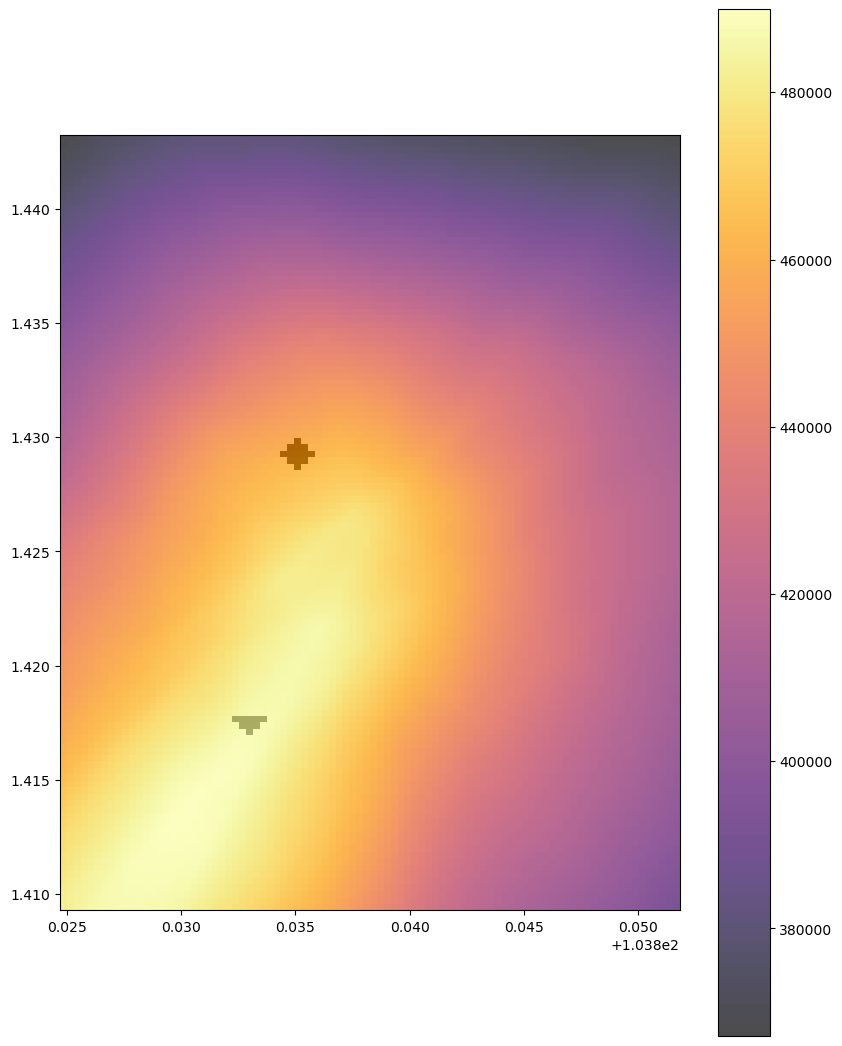

In [36]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))
#mrts = ["Yio Chu Kang MRT", "Ang Mo Kio MRT"]
#for mrt in mrts:
#  (i,j) = min_coords(*longLats[mrt])
#  #for m in range(3):
#  #  for n in range(3):
#  mrt_map[j+m-1][i+n-1] = 1

(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i-2]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+2]=1
mrt_map[j+1][i+1]=1
mrt_map[j+1][i]=1

"""
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[1]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

In [50]:
longLeft,longRight

(103.8288214, 103.8619606)

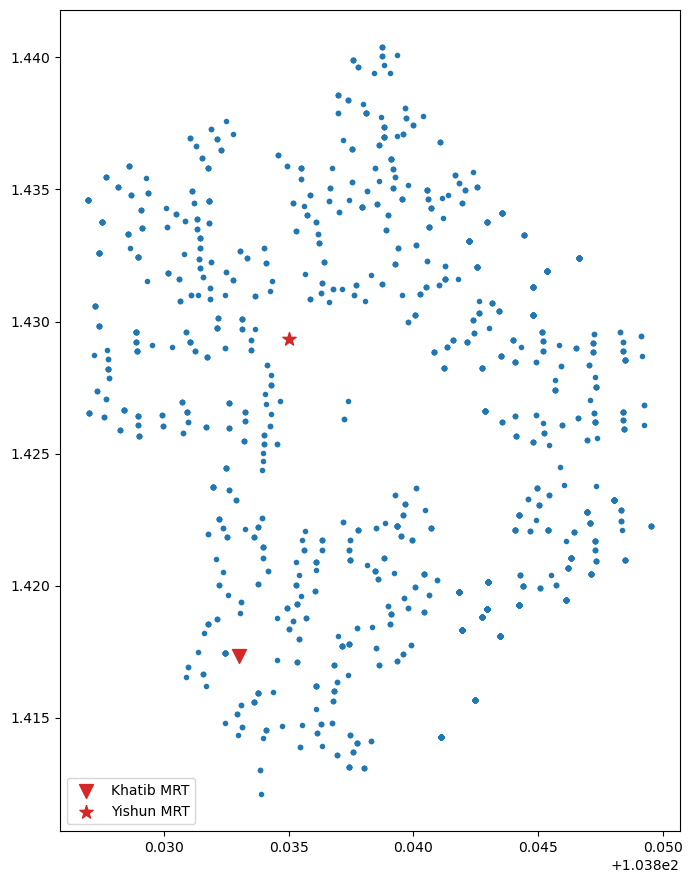

In [39]:
markers = ["v", "*"]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
